In [1]:
import litebird_sim as lbs
import numpy as np
from swipe_modules import SwipeSpinScanningStrategy
import matplotlib.pyplot as plt
import healpy as hp
import astropy

In [2]:
sim = lbs.Simulation(
    start_time=astropy.time.Time("2026-08-15T16:30"),
    duration_s=24*3600,
    description="SWIPE simulation",
    random_seed=12345
)
nside = 128

In [3]:
imo = lbs.Imo(flatfile_location="../../swipe_imo/IMO")

In [4]:
sim.set_scanning_strategy(SwipeSpinScanningStrategy(),delta_time_s=1)

instrument_info = lbs.InstrumentInfo.from_imo(url="/releases/v0.0/balloon/SWIPE/instrument_info",imo=imo,)
sim.set_instrument(instrument_info)

ch="145"
hwp_radpsec = instrument_info.hwp_rpm*2*np.pi/60.0
channel_info = lbs.FreqChannelInfo.from_imo(url="/releases/v0.0/balloon/SWIPE/"+ch+"/channel_info",imo=imo,)

site_latitude_deg, site_longitude_deg and longitude_speed_deg_per_sec used


In [5]:
dets=[]
detquats=[]
for detname in channel_info.detector_names[0:10]:
    det=lbs.DetectorInfo.from_imo(
        url="/releases/v0.0/balloon/SWIPE/"+ch+"/"+detname+"/detector_info",
        imo=imo,
    )
    dets.append(det)
    detquats.append(det.quat)

In [6]:
obs, = sim.create_observations(detectors=det)
sim.set_hwp(lbs.IdealHWP(hwp_radpsec))
sim.prepare_pointings()
sim.precompute_pointings()

In [7]:
Mbsparams = lbs.MbsParameters(make_cmb =True,
                              make_fg = True,
                              fg_models=["pysm_synch_0","pysm_dust_0"],
                              gaussian_smooth = False,
                              bandpass_int = False,
                              nside = nside,
                             )

In [8]:
mbs = lbs.Mbs(simulation=sim,
              parameters=Mbsparams,
              channel_list=channel_info,
             )

In [9]:
in_map = mbs.run_all()[0]

[2024-09-04 15:18:23,426 INFO MPI#0000] generating and saving cmb simulations
[2024-09-04 15:18:23,450 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-09-04 15:18:23,451 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-09-04 15:18:23,471 INFO MPI#0000] Access data from /Users/luca/Documents/Universita/LSPE/dev_swipe_modules/swipe_modules/examples/cmb/0000/cmb_0000_date_240904.fits
[2024-09-04 15:18:23,472 INFO MPI#0000] NSIDE = 128
[2024-09-04 15:18:23,472 INFO MPI#0000] ORDERING = RING in fits file
[2024-09-04 15:18:23,472 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-09-04 15:18:23,494 INFO MPI#0000] generating and saving fg simulations
[2024-09-04 15:18:23,495 INFO MPI#0000] Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
[2024-09-04 15:18:23,507 INFO MPI#0000] NSIDE = 512
[2024-09-04 15:18:23,508 INFO MPI#0000] ORDERING = RING in fits file
[2024-09-04 15:18:23,508 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-09-04 15:18:23,559 INFO MPI#0000] Retrieve data for 

In [10]:
sim.fill_tods(in_map)

In [11]:
sim.add_noise(random=sim.random,noise_type= "one_over_f")

In [12]:
results = sim.make_binned_map(nside)

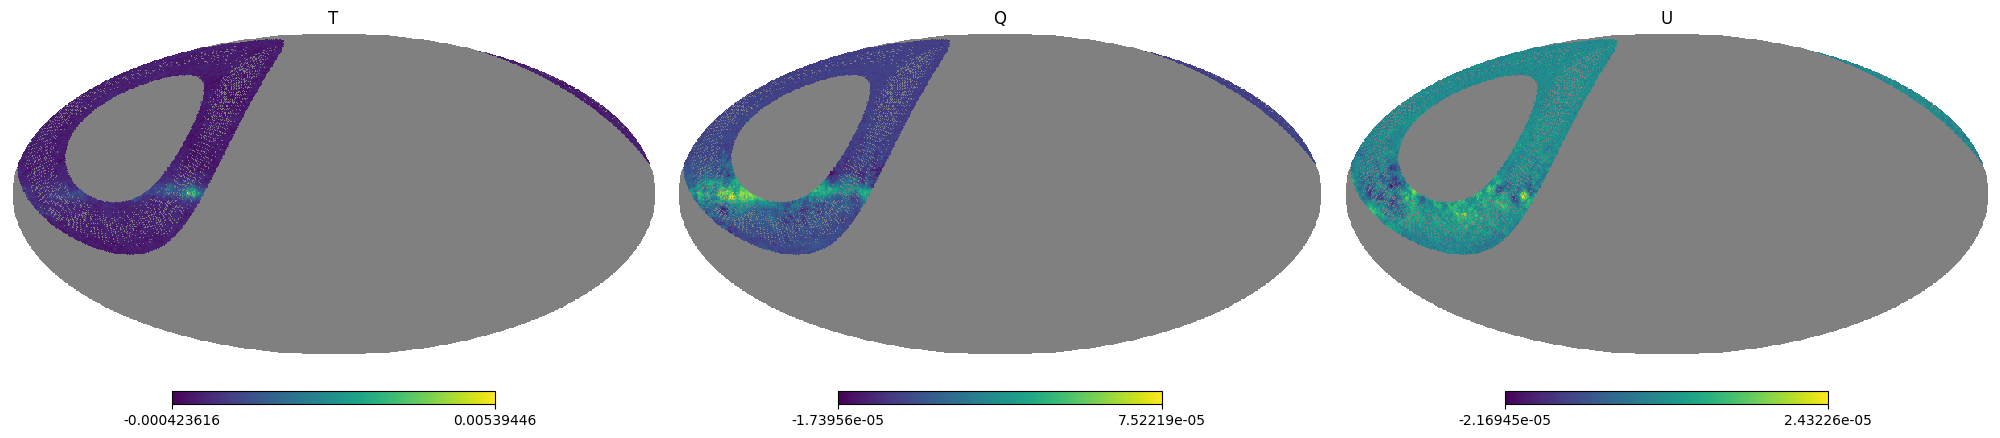

In [13]:
plt.figure(figsize=(20,7))
hp.mollview(results.binned_map[0],sub=131,title='T')
hp.mollview(results.binned_map[1],sub=132,title='Q')
hp.mollview(results.binned_map[2],sub=133,title='U')

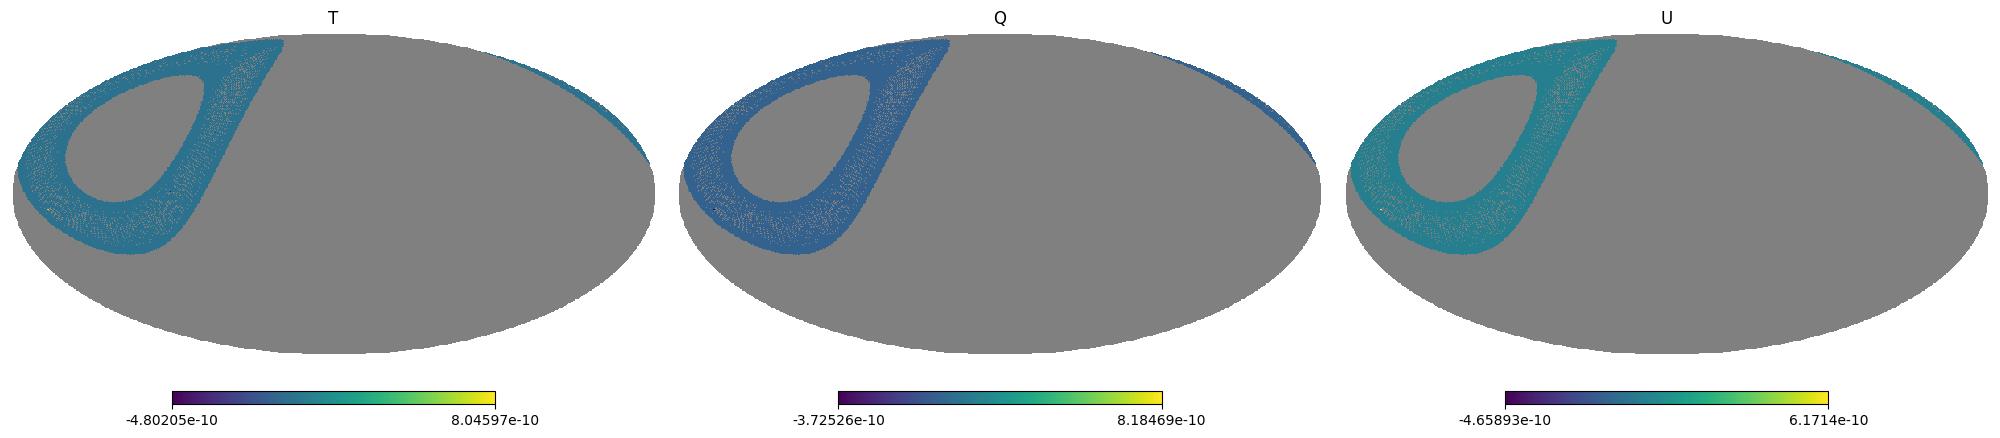

In [14]:
plt.figure(figsize=(20,7))
hp.mollview(results.binned_map[0]-in_map[ch][0],sub=131,title='T')
hp.mollview(results.binned_map[1]-in_map[ch][1],sub=132,title='Q')
hp.mollview(results.binned_map[2]-in_map[ch][2],sub=133,title='U')